In [1]:
import cvxpy as cp
import gurobipy as gp
import matplotlib.pyplot as plt
import math
import numpy as np
import time
from tqdm import tqdm

In [2]:
def preprocess_data(file_name):
    # assume: the data is stored in a csv file
    # data is of shape (N, 5) where N is the number of data points
    # columns are: x pos, y pos, orientation, speed, time
    # for some reason, the waypoint_logger always calculates the yaw as pi, 
    # so will ignore the orientation column for now
    data = np.loadtxt(file_name, delimiter=',')
    identical_rows = []
    for i, row in enumerate(data[1:]):
        if np.isclose(row[:-1], data[0, :-1]).all():
            identical_rows.append(i+1)
    # print("Removed %d rows (roughly) identical to the starting location" \
        #   % len(identical_rows))
    data = np.delete(data, identical_rows, axis=0)
    np.savetxt(file_name, data, delimiter=',')

    return data

# Point-mass model

In [3]:
class PointMassDynamics:

    def __init__(self, dt: float):
        self.dt = dt
        self.u_max = 1.0
        A_cont = np.r_[
            np.c_[np.zeros((2, 2)), np.eye(2)],
            np.c_[np.zeros((2, 2)), np.zeros((2, 2))]
        ]
        B_cont = np.r_[np.zeros((2, 2)), np.eye(2)]
        self.n = A_cont.shape[0]
        self.m = B_cont.shape[1]
        self.A_ = np.eye(self.n) + dt * A_cont
        self.B_ = dt * B_cont

    def forward(self, x, u): 
        return self.A_ @ x + self.B_ @ u

class PointMassMPC:

    def __init__(self, dyn: PointMassDynamics,
                       time_horizon: float, 
                       z: np.ndarray,
                       x_0: np.ndarray):
        # dynamics_class is an instatiation of the class above
        # time_horizon is the lookahead time
        # z: the trajectory we are tracking
        # x_0: current position
        self.dyn = dyn
        self.H = int(round(time_horizon / self.dyn.dt))
        self.z = z

        self.Q = np.eye(self.dyn.n)
        self.Q_f = np.eye(self.dyn.n)
        self.R = np.eye(self.dyn.m)
        self.x = None
        self.u = None
        self.cost = 0.
        self.constraints = []
        self.x_0 = x_0
            
        # initialize optimization problem
        self.init_prob()

    def init_prob(self):

        self.x = cp.Variable((self.H, self.dyn.n))
        self.u = cp.Variable((self.H - 1, self.dyn.m))
        self.constraints += [self.x[0, :] == self.x_0]
        for k in range(self.H - 1):
            self.cost += \
                cp.quad_form(self.x[k, :] - self.z[k, :], self.Q) + \
                cp.quad_form(self.u[k, :], self.R)
            self.constraints += [self.x[k + 1, :] == \
                self.dyn.forward(self.x[k, :], self.u[k, :])]
            self.constraints += [self.u[k, :] <= self.dyn.u_max]
            self.constraints += [-self.u[k, :] <= self.dyn.u_max]
        self.cost += cp.quad_form(self.x[self.H - 1, :] - self.z[self.H - 1, :], self.Q)
        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

Number of variables: 172
Number of equality constraints: 116
Number of inequality equality constraints: 112


100%|██████████| 2434/2434 [03:07<00:00, 13.00it/s]


Point-mass dynamics with cvxpy results:
Total time to track: 187.262387
Number of MPC problems solved: 2434
Average time per instance: 0.076936


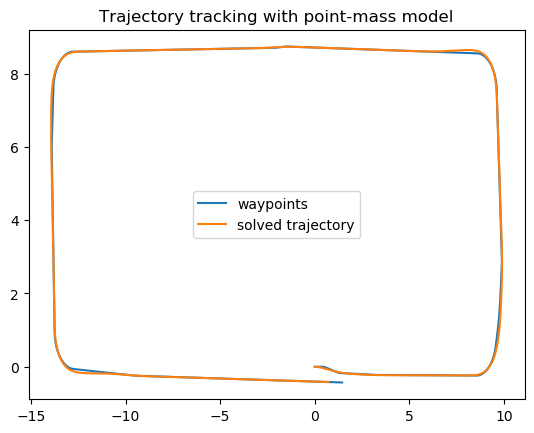

In [4]:
data_file = 'data/waypoints.csv'

data = preprocess_data(data_file)
N = data.shape[0]
x_pos = data[:, 0]
y_pos = data[:, 1]
orientation = data[:, 2]
speed = data[:, 3]
time_data = data[:, 4]
dt = np.mean(time_data[1:] - time_data[:-1])

# calculate x and y speed if needed
v_x = np.array([speed[k] * np.cos(orientation[k]) for k in range(N)])
v_y = np.array([speed[k] * np.sin(orientation[k]) for k in range(N)])

# plt.figure()
plt.plot(x_pos, y_pos, label='waypoints')

# dynamics class
linear_dyn = PointMassDynamics(dt)

# tracking data
z = np.c_[x_pos, y_pos, v_x, v_y]

# MPC tracking problem
x = [np.array(z[0, :])]
u = []
time_horizon = 1.5 # seconds
h = int(round(time_horizon / dt))

# print some info about the MPC problem
linear_mpc = PointMassMPC(linear_dyn, time_horizon, z[0:h, :], x[-1])
size_metrics = cp.problems.problem.SizeMetrics(linear_mpc.problem)
print("Number of variables:", size_metrics.num_scalar_variables)
print("Number of equality constraints:", size_metrics.num_scalar_eq_constr)
print("Number of inequality equality constraints:", 
        size_metrics.num_scalar_leq_constr)
linear_mpc.problem.solve()

start_time = time.perf_counter()
k = 0
for k in tqdm(range(N - h)):
    linear_mpc = PointMassMPC(linear_dyn, time_horizon, z[k:k+h, :], x[-1])
    linear_mpc.problem.solve()  # default is OSQP - faster than Gurobi
    # mpc.problem.solve(solver=cp.GUROBI)
    x.append(linear_mpc.x[1, :].value)
    u.append(linear_mpc.u[0, :].value)
    k += 1
total_time = time.perf_counter() - start_time

print("Point-mass dynamics with cvxpy results:")
print("Total time to track: %f" % total_time)
print("Number of MPC problems solved: %d" % (N - h))
print("Average time per instance: %f" % (total_time / (N - h)))

x = np.array(x)
u = np.array(u)

plt.plot(x[:, 0], x[:, 1], label="solved trajectory")
plt.title("Trajectory tracking with point-mass model")
plt.legend()
plt.show()

# Linearized bicycle model

In [5]:
class LinearBicycleDynamics:
    """
    Approximates bicycle model using linearization.
    x = (x_v, y_v, theta, velocity, delta)
    u = (a_long, v_delta)
    """

    def __init__(self, dt:float):
        self.dt = dt
        self.n, self.m = 5, 2
        self.wheelbase = .324
        delta_lim = np.deg2rad(30)
        delta_dot_lim = np.deg2rad(60)
        v_lim = 3.0
        a_lim = 2.0
        self.x_min = np.array([-np.inf, -np.inf, -np.inf, -v_lim, -delta_lim])
        self.x_max = np.array([ np.inf,  np.inf,  np.inf,  v_lim,  delta_lim])
        self.u_min = np.array([-a_lim, -delta_dot_lim])
        self.u_max = np.array([ a_lim,  delta_dot_lim])

    def f_(self, x, u):
        return np.array([
            x[3] * np.cos(x[2]),
            x[3] * np.sin(x[2]),
            x[3] / self.wheelbase * np.tan(x[4]),
            u[0],
            u[1]
        ])   

    def A_(self, x=np.zeros(5), u=np.zeros(2)):
        # df/dx evaluated at given x, u
        return np.array([
            [0, 0, -x[3] * np.sin(x[2]), np.cos(x[2]), 0],
            [0, 0,  x[3] * np.cos(x[2]), np.sin(x[2]), 0],
            [0, 0, 0, 1./self.wheelbase * np.tan(x[4]), x[3] / self.wheelbase * (1 / np.cos(x[4]))**2],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]
        ])

    def B_(self, x=np.zeros(5), u=np.zeros(2)):
        # df/du evaluated at given x, u
        return np.r_[np.zeros((3, 2)), np.eye(2)]
    
    def forward(self, x, u, x_bar, u_bar=np.zeros(2)):
        return x_bar + self.dt * self.f_(x_bar, u_bar) + \
            (np.eye(self.n) + self.dt * self.A_(x_bar, u_bar)) @ (x - x_bar) + \
            self.dt * self.B_() @ (u - u_bar)


class LinearBicycleMPC:

    def __init__(self, dyn: LinearBicycleDynamics,
                       time_horizon: float, 
                       z: np.ndarray,
                       x_0: np.ndarray):
        # dynamics_class is an instatiation of the class above
        # time_horizon is the lookahead time
        # z: the trajectory we are tracking
        # x_0: current position
        self.dyn = dyn
        self.H = int(round(time_horizon / self.dyn.dt))
        self.z = z

        self.Q = np.eye(self.dyn.n)
        self.Q[-1, -1] = 0
        self.Q[3, 3] = 0
        self.Q_f = np.eye(self.dyn.n)
        self.Q_f[-1, -1] = 0
        self.Q_f[3, 3] = 0
        self.R = np.eye(self.dyn.m)
        self.x = None
        self.u = None
        self.cost = 0.
        self.constraints = []
        self.x_0 = x_0
            
        # initialize optimization problem
        self.init_prob()

    def init_prob(self):

        self.x = cp.Variable((self.H, self.dyn.n))
        self.u = cp.Variable((self.H - 1, self.dyn.m))

        self.constraints += [self.x[0, :] == self.x_0]

        for k in range(self.H - 1):

            self.cost += \
                cp.quad_form(self.x[k, :] - self.z[k, :], self.Q) + \
                cp.quad_form(self.u[k, :], self.R)

            self.constraints += [self.x[k + 1, :] == \
                self.dyn.forward(x=self.x[k, :], u=self.u[k, :], x_bar=self.x_0)]
            self.constraints += [
                self.x[k, :] <= self.dyn.x_max, self.x[k, :] >= self.dyn.x_min,
                self.u[k, :] <= self.dyn.u_max, self.u[k, :] >= self.dyn.u_min
            ]

        self.cost += cp.quad_form(self.x[self.H - 1, :] - self.z[self.H - 1, :], self.Q)
        self.constraints += [
            self.x[self.H - 1, :] <= self.dyn.x_max, self.x[self.H - 1, :] >= self.dyn.x_min,
        ]
        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

Number of variables: 201
Number of equality constraints: 145
Number of inequality equality constraints: 402


100%|██████████| 2434/2434 [04:20<00:00,  9.34it/s]


Linearized bicycle dynamics with cvxpy results:
Total time to track: 260.505179
Number of MPC problems solved: 2434
Average time per instance: 0.107028


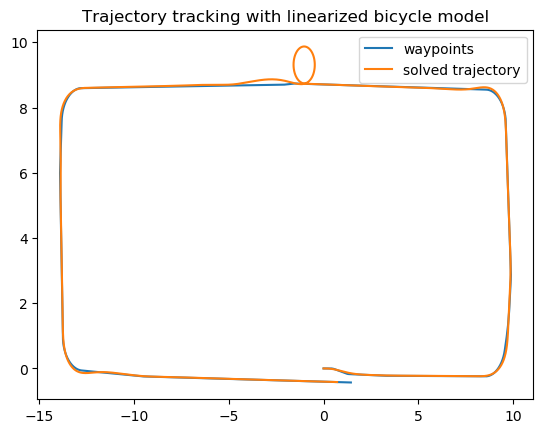

In [6]:
data_file = 'data/waypoints.csv'

data = preprocess_data(data_file)
N = data.shape[0]
x_pos = data[:, 0]
y_pos = data[:, 1]
orientation = data[:, 2]
speed = data[:, 3]
time_data = data[:, 4]
dt = np.mean(time_data[1:] - time_data[:-1])

# plt.figure()
plt.plot(x_pos, y_pos, label='waypoints')

# dynamics class
linear_bicycle_dyn = LinearBicycleDynamics(dt)

# tracking data
z = np.c_[x_pos, y_pos, orientation, speed, np.zeros_like(x_pos)]

# MPC tracking problem
x = [np.array(z[0, :])]
u = []
time_horizon = 1.5 # seconds
h = int(round(time_horizon / dt))

# print some info about the MPC problem
linear_bicycle_mpc = LinearBicycleMPC(linear_bicycle_dyn, time_horizon, z[0:h, :], x[-1])
size_metrics = cp.problems.problem.SizeMetrics(linear_bicycle_mpc.problem)
print("Number of variables:", size_metrics.num_scalar_variables)
print("Number of equality constraints:", size_metrics.num_scalar_eq_constr)
print("Number of inequality equality constraints:", 
        size_metrics.num_scalar_leq_constr)
linear_bicycle_mpc.problem.solve()

start_time = time.perf_counter()
k = 0
for k in tqdm(range(N - h)):
    linear_bicycle_mpc = LinearBicycleMPC(linear_bicycle_dyn, time_horizon, z[k:k+h, :], x[-1])
    linear_bicycle_mpc.problem.solve()  # default is OSQP - faster than Gurobi
    # mpc.problem.solve(solver=cp.GUROBI)
    x.append(linear_bicycle_mpc.x[1, :].value)
    u.append(linear_bicycle_mpc.u[0, :].value)
    k += 1
total_time = time.perf_counter() - start_time

print("Linearized bicycle dynamics with cvxpy results:")
print("Total time to track: %f" % total_time)
print("Number of MPC problems solved: %d" % (N - h))
print("Average time per instance: %f" % (total_time / (N - h)))

x = np.array(x)
u = np.array(u)

plt.plot(x[:, 0], x[:, 1], label="solved trajectory")
plt.title("Trajectory tracking with linearized bicycle model")
plt.legend()
plt.show()

### Hmm, some weird behavior here

Not sure why this is happening and haven't had a chance to investigate.

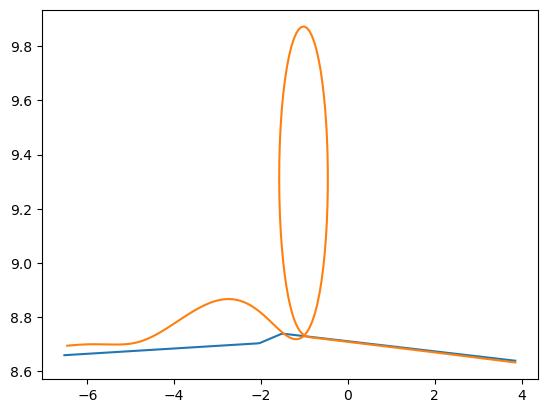

In [7]:
n1, n2 = 900, 1300
plt.plot(z[n1:n2, 0], z[n1:n2, 1], label='waypoints')
plt.plot(x[n1:n2:, 0], x[n1:n2, 1], label="solved trajectory");

# Bicycle model

So far, unable to get this one to work

In [8]:
class BicycleDynamics:

    def __init__(self, dt: float):
        self.dt = dt
        self.n, self.m = 5, 2
        self.wheelbase = .324
        delta_lim = np.deg2rad(30)
        delta_dot_lim = np.deg2rad(60)
        v_lim = 3.0
        a_lim = 2.0
        self.x_min = np.array([-np.inf, -np.inf, -np.inf, -v_lim, -delta_lim])
        self.x_max = np.array([ np.inf,  np.inf,  np.inf,  v_lim,  delta_lim])
        self.u_min = np.array([-a_lim, -delta_dot_lim])
        self.u_max = np.array([ a_lim,  delta_dot_lim])

    def forward(self, x, u):
        f_x = np.array([x[0] + self.dt * x[3] * math.cos(x[2]), 
                        x[1] + self.dt * x[3] * math.sin(x[2]),
                        x[2] + self.dt * x[3] / self.wheelbase * math.tan(x[4]),
                        x[3],
                        x[4]])
        g_x = self.dt * np.r_[np.zeros((3, 2)), np.eye(2)]
        return f_x + g_x @ u


class BicycleMPC:

    def __init__(self, dyn: BicycleDynamics, 
                       time_horizon: float, 
                       z: np.ndarray,
                       x_0: np.ndarray,
                       x_init=None,
                       u_init=None):
        # dynamics_class is an instatiation of the class above
        # time_horizon is the lookahead time
        # z: the trajectory we are tracking
        # x_0: current position
        self.dyn = dyn
        self.H = int(round(time_horizon / self.dyn.dt))
        self.z = z
        self.x_init = x_init
        self.u_init = u_init

        self.Q = np.eye(2)
        # self.Q = np.eye(self.dyn.n)
        # self.Q[-1, -1] = 0
        # self.Q[-2, -2] = 0
        # self.Q[-3, -3] = 0
        # self.R = np.zeros((self.dyn.m, self.dyn.m))
        self.x = None
        self.u = None
        self.cost = 0.
        self.constraints = []
        self.x_0 = x_0

        self.init_prob()

    def init_prob(self):
        m = gp.Model()
        m.params.OutputFlag = 0
        m.params.NonConvex = 2
        m.params.BarConvTol = 1e-2  # increase tolerance from default 1e-8

        self.x = m.addMVar(shape=(self.H, self.dyn.n))
        if type(self.x_init) == np.ndarray:
            self.x.Start = self.x_init
        self.x_trig = m.addMVar(shape=(self.H, 3))

        self.u = m.addMVar(shape=(self.H - 1, self.dyn.m))
        if type(self.u_init) == np.ndarray:
            self.u.Start = self.u_init

        self.cost = 0
        m.addConstr(self.x[0, :] == self.x_0)
        for k in range(self.H - 1):
            # self.cost += self.u[k, :] @ self.R @ self.u[k, :]
            # self.cost += (self.x[k, :] - self.z[k, :]) @ self.Q @ (self.x[k, :] - self.z[k, :])
            self.cost += (self.x[k, :2] - self.z[k, :2]) @ self.Q @ (self.x[k, :2] - self.z[k, :2])

            m.addGenConstrCos(self.x[k, 2], self.x_trig[k, 0])
            m.addConstr(self.x[k+1, 0] ==  self.x[k, 0] + self.dyn.dt * self.x[k, 3] * self.x_trig[k, 0])

            m.addGenConstrSin(self.x[k, 2], self.x_trig[k, 1])
            m.addConstr(self.x[k+1, 1] ==  self.x[k, 1] + self.dyn.dt * self.x[k, 3] * self.x_trig[k, 1])

            m.addGenConstrTan(self.x[k, 4], self.x_trig[k, 2])
            m.addConstr(self.x[k+1, 2] == self.x[k, 2] + self.dyn.dt * self.x[k, 3] / self.dyn.wheelbase * self.x_trig[k, 2])

            m.addConstr(self.x[k+1, 3] == self.x[k, 3] + self.dyn.dt * self.u[k, 0])

            m.addConstr(self.x[k+1, 4] == self.x[k, 4] + self.dyn.dt * self.u[k, 1])

            m.addConstr(self.x[k+1, :] <= self.dyn.x_max)
            m.addConstr(self.x[k+1, :] >= self.dyn.x_min)
            m.addConstr(self.u[k, :] <= self.dyn.u_max)
            m.addConstr(self.u[k, :] >= self.dyn.u_min)

        # self.cost += (self.x[self.H-1, :] - self.z[self.H-1, :]) @ self.Q @ (self.x[self.H-1, :] - self.z[self.H-1, :])
        self.cost += (self.x[self.H-1, :2] - self.z[self.H-1, :2]) @ self.Q @ (self.x[self.H-1, :2] - self.z[self.H-1, :2])
        m.setObjective(self.cost, gp.GRB.MINIMIZE)
        self.problem = m

In [9]:
# data_file = 'data/waypoints.csv'

# data = preprocess_data(data_file)
# N = data.shape[0]
# x_pos = data[:, 0]
# y_pos = data[:, 1]
# orientation = data[:, 2]
# speed = data[:, 3]
# time_data = data[:, 4]
# dt = np.mean(time_data[1:] - time_data[:-1])

# # plt.figure()
# plt.plot(x_pos, y_pos, label='waypoints')

# # dynamics class
# bicycle_dyn = BicycleDynamics(dt)

# # tracking data
# z = np.c_[x_pos, y_pos, orientation, speed, np.zeros_like(x_pos)]

# # MPC tracking problem
# x = [np.array(z[0, :])]
# u = []
# time_horizon = 1.0 # seconds
# h = int(round(time_horizon / dt))

# start_time = time.perf_counter()
# k = 0
# nonlinear_mpc = BicycleMPC(bicycle_dyn, time_horizon, z[0:h, :], x[-1])
# nonlinear_mpc.problem.optimize()
# x.append(nonlinear_mpc.x[1, :].X)
# u.append(nonlinear_mpc.u[0, :].X)
# x_init, u_init = np.zeros_like(nonlinear_mpc.x.X), np.zeros_like(nonlinear_mpc.u.X)
# x_init[:-1, :] = nonlinear_mpc.x.X[1:, :]
# x_init[-1, :] = nonlinear_mpc.x.X[-1, :]
# u_init[:-1, :] = nonlinear_mpc.u.X[1:, :]

# k = 0
# N = N
# for k in tqdm(range(1, N - h)):
#     nonlinear_mpc = BicycleMPC(bicycle_dyn, time_horizon, z[k:k+h, :], x[-1], x_init=x_init, u_init=u_init)
#     nonlinear_mpc.problem.optimize()
#     x.append(nonlinear_mpc.x[1, :].X)
#     u.append(nonlinear_mpc.u[0, :].X)
#     x_init, u_init = np.zeros_like(nonlinear_mpc.x.X), np.zeros_like(nonlinear_mpc.u.X)
#     x_init[:-1, :] = nonlinear_mpc.x.X[1:, :]
#     x_init[-1, :] = nonlinear_mpc.x.X[-1, :]
#     u_init[:-1, :] = nonlinear_mpc.u.X[1:, :]
#     k += 1

# total_time = time.perf_counter() - start_time

# print("Bicycle dynamics with gurobipy results:")
# print("Total time to track: %f" % total_time)
# print("Number of MPC problems solved: %d" % (N - h))
# print("Average time per instance: %f" % (total_time / (N - h)))

# x = np.array(x)
# u = np.array(u)

# plt.plot(x[:, 0], x[:, 1], label="solved trajectory")
# plt.title("Trajectory tracking with bicycle model")
# plt.legend()
# plt.show()